# Coastal Current

## Governing Equations
In the farfield, where the jet has deflected and settled into geostrophic balance oriented parallel to isobaths, the steady continuity and momentum equations are

$$ \frac{\partial }{\partial s}(VH) + \frac{\partial \alpha}{\partial n} = 0 $$ 

$$ 
V\frac{\partial V}{\partial s} +  
C_D \frac{V^2}{H}  +
g \frac{\partial \eta}{\partial s}  = 0 
$$

$$ 
V^2 K +
fV +
g \frac{\partial \eta}{\partial n}  = 0
$$

**note**: the nonlinear term in the normal component is retained to account for the curvature of isobaths to be expected around and island

Due to the azimuthally periodic boundary conditions naturally arising from the problem geometry, it is actually not possible to support a net free-surface slope, in that direction i.e. $\int g\frac{\partial \eta(r,\theta)}{\partial \theta}\partial \, \theta = 0$. Thus, once the flow aligns to isobaths directly oriented to the azimuthal coordinate, it is reasonable to argue that $g\frac{\partial \eta}{\partial s} \approx 0$ once the coastal current has been established.

As a consequence, equation (1) reduces to 

$$V \frac{\partial V}{\partial s} = -C_D \frac{V^2}{H} $$,

an ordinary differential equation that can be solved by separation of variables, admitting the solution

$$ V(s) = V_0 e^{-\frac{C_D}{H}s} $$

And so an e-folding decay length scale ($\mathbb{S}$) can be established 
$$\mathbb{S} = 3\frac{H}{C_D}$$

($e^{-3}$ decays to 5% of the inital value, while $e^{-4}$ decays to 1.8%) 
providing rough estimate of the alongshore extent of the feature before it is dissipated by friction. Note that in order to satisfy continuity, the streamwise confluence due to frictional damping of the velocity field would induce radial spreading of the jet.

In our problem, where $H(r) = H_0 + \lambda (r - R_i)$, 

$$\mathbb{S} = 3 \frac{ H_0 + \lambda (R - R_i)}{C_d}$$

where R is the offshore extent of the jet before it aligns to isobaths. 

$$\frac{\mathbb{S}}{{W_r}} \sim  \frac{H_0 + \lambda R}{W_rC_d}$$

suggesting that the intensity of jet-jet interaction increases given a larger jet excursion distance or a reduced drag coefficient, as the flow is less likely to retard. In the limiting case of $R\rightarrow \infty$, however there should be no jet-jet interaction when this simple scaling indicates otherwise. However in actuality, as $R$ increases, the initial speed of the coastal current would also decay, as the jet must obey continuity on a slope, due to both topography and diffluence, and so in the limit $R\rightarrow \infty$, $V_0 \rightarrow 0$ too. We can derive an approximate decay scale for the speed of the assumming jet streamlines are aligned to the radial coordinate (rather than azimuthal in the farfield), which in the nearfield is a good assumption. From  continuity, ignoring diffluence 

$$ V(s)' = -\frac{V\lambda}{H_0 + \lambda s}$$ 

admits the simple solution 

$$V(s) = \frac{V_0H_0}{H_0 + \lambda s}$$

giving the scale $\mathcal{S} = \frac{9H_0}{\lambda}$ at where $V(s)\approx 0.1V_0$. 


<!-- Comparing this scale with the inertial radius of the flow $(V/f)$ offers a reasonable guide as to whether the flow will successfully deflect and orient itself to isobaths before fizzling out, simply du -->

<!-- which can be solved to give $V(s) = V_0e^{-\frac{\lambda}{H}s}$ with a 95% e-folding spatial scale $\mathcal{S} = 3\frac{H}{\lambda}$ -->



## Analytic solution

After invoking continuity ($\frac{\partial V}{\partial s} = -\frac{V}{H}\frac{\partial H}{\partial s} -V\frac{\partial \alpha}{\partial n}$), equation (1) becomes

$$ V( -\frac{V}{H}\frac{\partial H}{\partial s} - V \frac{\partial \alpha}{\partial n} ) + C_D \frac{V^2}{H} + g\frac{\partial \eta}{\partial s} = 0 $$

Assuming the center streamline is oriented purely radially ($\hat{s}\sim\hat{r}$) after recognizing that $H = H_0 + \lambda s$ and $\frac{\partial H}{\partial s}  = \lambda $, and ignoring diffluence, the equation can be simplified to

$$ \frac{-V^2\lambda}{H_0 + \lambda s} + C_D\frac{V^2}{H_0 + \lambda s} + g\frac{\partial \eta}{\partial s} = 0 $$

which is a separable first order ODE for the free surface

$$ \eta(s)^{'} = \frac{V^2(s)(\lambda - C_D)}{g(H_0 + \lambda s)} $$

which, after invoking the solution for $V(s)$

$$ \eta(s)^{'} = \frac{V_0^2H_0^2(\lambda - C_D)}{g(H_0 + \lambda s)^3} $$

admits the analytic solution
 
$$\eta(s) = 
\frac{V_0^2H_0^2(C_D - \lambda )}{2 g \lambda(H_0 + \lambda s)^2} - 
\frac{V_0^2(C_D - \lambda )}{2 g \lambda} +
\eta_0
$$
<!-- which can be solved numerically after substituting in the continuity solution $V(s) = \frac{V_0}{H_0 + \lambda(s - R_i)}$ -->

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import holoviews as hv
import hvplot.pandas

class momentumAnalysis():
    
    g = 9.81
    
    def __init__(self, V0 = 0.25, H0 = 20, 𝜆 = 0.1, Cd = 0.0625, W = 1e3, latitude = -30):
        self.V0 = V0
        self.H0 = H0
        self.𝜆 = 𝜆 
        self.Cd = Cd
        self.W = W
        self.f = 2*7.29e-5*np.sin(latitude*np.pi/180)
        
    def eta_init(self):
        """Compute initial free surface slope based on cyclogeostrophic balance.
            Assume initial curvature is set by the nearfield inertial radius V0/f then integrate the normal momentum equation"""
        self.𝜂0 = -self.W*self.f*self.V0/self.g
    
    def depth(self,s): #,H0,𝜆):
        """Compute depth profile """
        return self.H0 + self.𝜆*s
        
    def speed(self,s): #, V0 = 0.25, H0 = 20, 𝜆 = 0.1):
        return self.V0*self.H0/(self.H0 + self.𝜆*s)
    
    def speed_grad(self,s):
        return -self.V*self.𝜆/(self.H0+s*self.𝜆)
    
    def eta(self, s, 𝜂0 = 0.1, V0 = .25, Cd = 1e-3, 𝜆 = 0.1, H0 = 20, g = 9.81):
        return -V0**2*H0**2*(Cd - 𝜆)/(2*g*𝜆*(𝜆*s + H0)**2) - V0**2*(Cd - 𝜆)/(2*g*𝜆) + 𝜂0
        
    def free_surface(self,s): #, 𝜂0 = 0.1, V0 = .25, Cd = 1e-3, 𝜆 = 0.1, H0 = 20, g = 9.81):
        #return -V0**2*(Cd - 1/𝜆)/(2*g*𝜆*(𝜆*s + H0)**2) + V0**2*(Cd - 1/𝜆)/(2*g*𝜆*H0**2) + 𝜂0
        return   self.V0**2*self.H0**2*(self.Cd - self.𝜆)/(2*self.g*self.𝜆*(self.𝜆*s + self.H0)**2) + \
                -self.V0**2*(self.Cd - self.𝜆)/(2*self.g*self.𝜆) + self.𝜂0
    
    def eta_slope(self, s):#, V0 = .25, Cd = 1e-3, 𝜆 = 0.1, H0 = 20, g = 9.81):
        return self.V0**2*self.H0**2*(self.𝜆 - self.Cd)/(self.g*(self.H0 + self.𝜆*s)**3)

    def dia_sw(self, dvds,V,Cd,H,dnds): # g = 9.81):
        nl = V*dvds
        drag = Cd*V**2/H
        pgf = self.g*dnds
        return nl, drag, pgf

    def state(self,s):
        self.s = s
        self.H = self.depth(s)
        self.V = self.speed(s)
        self.eta_init()
        self.𝜂 = self.free_surface(s)
        self.dvds = self.speed_grad(s)
        self.d𝜂ds = self.eta_slope(s)
        
        self.sw_nlr, self.sw_drg, self.sw_pgf = self.dia_sw(self.dvds, self.V, self.Cd, self.H, self.d𝜂ds)
    
    def excursion(self,r): #,v0,h0,𝜆,g):
        """use conservation of normal momentum to solve for r."""
        Vf = self.V0*self.H0/(self.H0+self.𝜆*r)
        detadn_i = self.𝜂0/self.W
        detadn_f = self.eta(r, 𝜂0 = self.𝜂0, V0 = self.V0, Cd = self.Cd, 𝜆 = self.𝜆, H0 = self.H0, g = self.g)/r
        
        return -Vf**2/( self.f*(2*self.V0 - Vf) + self.g*(detadn_i - detadn_f) ) - r
    
    def excursion_solve(self):
        return fsolve(self.excursion, 5e3)
    
    def make_df(self):
        names = ["s", "depth", "speed", "𝜂", "dnds", "dvds", "nonlinear", "drag", "pgf"]
        data = [self.s, self.H, self.V, self.𝜂, self.d𝜂ds, self.dvds, self.sw_nlr, self.sw_drg, self.sw_pgf]
        df = pd.DataFrame.from_dict(dict(zip(names,data)))
        return df

/Users/WalterTorres/opt/anaconda3/envs/viz/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in true_divide


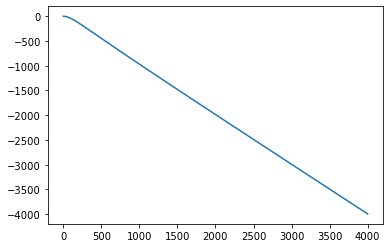

In [76]:
s = np.linspace(0, 2e3, 1000)  
r = np.linspace(0,4e3, 1000)

V0 = 0.25
H0 = 20
𝜂0 = 0.01
𝜆 = 0.1
Cd = 0.03
M = momentumAnalysis(V0 = V0, H0 = H0, 𝜆 = 𝜆, Cd = Cd)
M.state(s)
R = M.excursion_solve()
df = M.make_df()

value = M.excursion(r)
sns.lineplot(r, value)

In [ ]:
zero = hv.HLine(0).opts(line_width = 1, color = "k", alpha = .25)
(df.hvplot.line(x = "s", y = ["nonlinear", "drag", "pgf"]) * zero +
 df.hvplot.line(x = "s", y = "𝜂") * zero).cols(1)

### sandbox 
which can be non-dimensionalized by introducing $s = Rs^*$ as the offset distance, use the wave height $\eta = H_s\eta^*$ as a naive scaling for the free surface variation, the bathymetric slope for the topographic continuity term scale $\lambda \approx \frac{\partial H}{\partial s}$, and a typical jet spreading angle ($d\sigma = 15^{\circ}= \pi/24$) over the jet width $W_J$

$$ \lambda \frac{V^2}{H} - \frac{\pi}{24}\frac{V^2}{W_J} + C_D\frac{V^2}{H} + \frac{g H_s}{R}\frac{\partial \eta^*}{\partial s^*} = 0$$
where $H(r) \sim \lambda R$ can be substituded in and terms rearranged to solve for $R$

$$ R = \frac{24W_J}{\pi}\big[ \frac{g H_s}{V^2}\frac{\partial \eta^*}{\partial s^*} + 1 + \frac{C_D}{\lambda} )\big]
            $$


Using continuity w/ $H = h + \eta$ in combination with the streamwise momentum equation gives us two equations and two unknowns $(V,\eta)$. Combining we get

$$ V' = \frac{-C_D\frac{V^2}{H} + g\lambda}{V + \frac{gH}{V}} $$

which can be analytically solved?

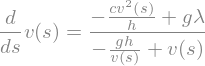

In [4]:
import sympy as sym
sym.init_printing()

s = sym.symbols('s', real = True)
l, g, c, h, v0 = sym.symbols('lambda g c h, v0', real = True, constant = True)

v = sym.Function('v')(s)
dvds = v.diff(s)
expr = sym.Eq(dvds, (-c*v**2/h + g*l)/(v - g*h/v) )
expr

In [319]:
sol = sym.dsolve(expr)

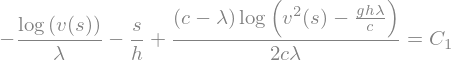

In [320]:
display(sol)#sym.simplify(sol))

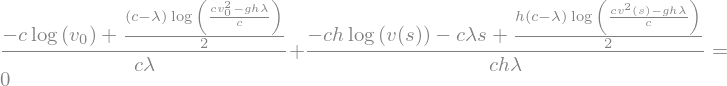

In [321]:
c1 = sol.subs(v, V0).subs(s, 0).lhs
eqn = sym.Eq(sol.lhs, c1)
solution = sym.Eq( eqn.simplify().lhs + eqn.simplify().rhs, 0)
solution

In [307]:
f = sym.lambdify( (s, l, g, c, h, v0), solution.lhs, "math")
help(f)

Help on function _lambdifygenerated:

_lambdifygenerated(s, lambda_, g, c, h, v0)
    Created with lambdify. Signature:
    
    func(s, lambda, g, c, h, v0)
    
    Expression:
    
    (-c*log(v0) + (c + lambda)*log((c*v0**2 - g*h*lambda)/c)/2)/(c*lambda) +...
    
    Source code:
    
    def _lambdifygenerated(s, lambda_, g, c, h, v0):
        return ((-c*log(v0) + (1/2)*(c + lambda_)*log((c*v0**2 - g*h*lambda_)/c))/(c*lambda_) + (-c*h*log(v(s)) + c*lambda_*s + (1/2)*h*(c + lambda_)*log((c*v(s)**2 - g*h*lambda_)/c))/(c*h*lambda_))
    
    
    Imported modules:



In [1]:
from scipy.optimize import fsolve

args = (1, 9.81, 0.01, 20, 0.25)
fsolve(f, 0.25, args = args)

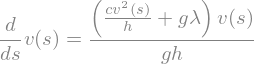

In [287]:
#simplify assume gh/v >> V
expr = sym.Eq(dvds, (c*v**2/h + g*l)/(g*h/v) )
expr

In [289]:
sol2 = sym.dsolve(expr)

In [ ]:
display(sol2)

In [2]:
args = (.1,9.81,0.01,20)
f(s, *args)

## Normal direction


Assuming the initial motion of the jet is inertial, i.e. $K = \frac{f}{V_J}$, its initial net potential vorticity is 0. If PV is conserved as it evolves into the alongshore current along the isobath with radius of curvature $R = r + R_i$ where $R_i$ is the island radius, and that the radial and normal directions are coincindent

$$ f - \frac{dV}{dr} + \frac{V}{R} = 0 $$

This can be separated and integrated to solve for $V$ using the no-slip boundary condition $V(r = 0) = 0$

$$ V = fR\log{ \frac{R}{R_i} } $$

Now we can apply conservation of mass to estimate the width of the coastal current $R_c$ for a given outflow mass flux $Q_0 = V_JW_JH_0$.

$$ \int_{0}^{R_c} V(r)h(r) dr = Q_0 $$

With a known depth $h(r) = H_0 + \lambda r$ and velocity profile, the above can be integrated solved for $R_c$

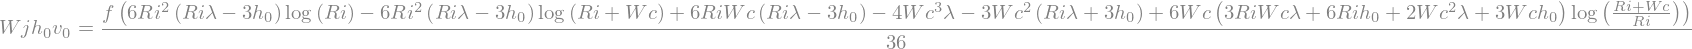

In [552]:
#v = sym.Function('v')(n)
r = sym.symbols('r', real = True)
h0, v0, q0, l, f, Ri, Wc, Wj = sym.symbols('h0 v0 q0 lambda f Ri Wc Wj', real = True, constant = True)
R = r + Ri
v = f*R*sym.log(R/Ri) #define velocity function
h = h0 + l*r #define depth profile
expr = v*h #integrand
result =  sym.integrate(expr,(r,0,Wc))
eqn = sym.Eq(result,v0*h0*Wj)
fn = (result - v0*h0*Wj)
eqn.simplify()

which although a bit unwieldy and very nonlinear, can be solved implicitly using scipy's *fsolve* root finding function. For the parameters used in model simulations
$\lambda = 0.1, H_0 = 20m, R_i = 12e3, f = 3.6e-5, W_J = 1000, V_0 = 0.25 m/s$

In [558]:
from IPython.display import display, Math
F = sym.lambdify( (Wc,l,h0,Ri,f,Wj,v0), fn, 'numpy')
Fv = sym.lambdify((f,r,Ri), v)
wc = fsolve(F, 1e3, args = (0.1, 20, 12e3, 3.645e-5, 1000, 0.25) )
vc = Fv(3.645e-5,wc,12e3)
display(Math(fr"$W_c = {int(wc[0])} m$"))
display(Math(fr"$V_c = {vc[0]:0.3f} m/s$"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [220]:
from scipy.optimize import fsolve


r, n = sym.symbols('r n', real = True)
v = sym.Function('v')(n)
𝜂 = sym.Function('eta')(n)

h0, v0, q0, l, f, Ri, c1 = sym.symbols('h0 v0 q0 lambda f Ri c1 c2', real = True, constant = True)

expr = sym.Eq(f, v0*h0*(-1/( (h0+l*r)*(r)) + 1/(r*(h0+l*r) ) ) )
expr

In [83]:
# sym.solve(expr,'r')
def cons_pv(r, h0 = 20, v0 = 0.25, 𝜆 = 0.1, f = -3e-5):
    return v0*h0*(-1/( (h0+𝜆*r)*r + 1/( r*(h0+𝜆*r) )) - f

# fsolve(cons_pv, 5e3)

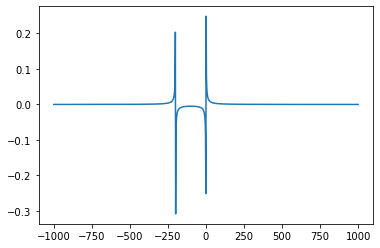

In [86]:
r = np.linspace(-1e3,1e3,1000)

value = cons_pv(r)
sns.lineplot(r,value)

In [382]:
(dvdn + vk + f)/h0 = (dvdn + v/r + f)/(h0 + r*l)
dvdn = -v/r - f


SyntaxError: can't assign to operator (<ipython-input-382-9ff03fbfd973>, line 1)

## free surface solution

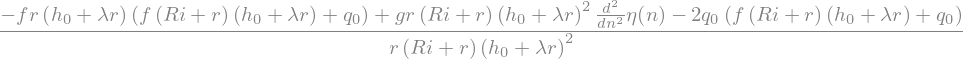

In [427]:
expr = v**2/(r)
+ f*v + g*𝜂.diff(n) #take normal derivative of momentum equation
shear = expr.diff(n).subs(v.diff(n), -v/(r+Ri) - f).subs(v, q0/(h0 + l*r)).simplify() #substitute conservation of pv
shear #.simplify()

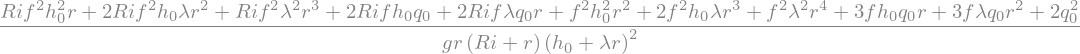

In [428]:
expr = sym.solve(sym.Eq(shear, 0), 𝜂.diff(n).diff(n))
#sol = sym.integrate(sym.integrate(expr[0], r) + c1, r) #.simplify() 

#sym.Eq( (sol + c2).simplify(i
expr[0].simplify()

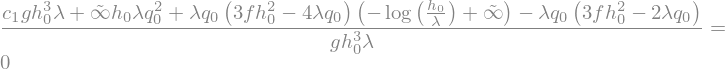

In [394]:
#sol.diff(r).simplify()
sym.Eq(sol.diff(r).subs(r,0),0)

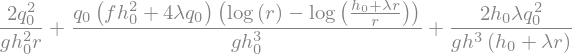

In [373]:
#Apply bc's dn/dr(r = 0) = 0 no slip

#bc1 = 2*f*q0*(-1 + sym.log(r) - sym.log(h0/l) )/(g*h0) + 2*q0**2/(h0**2*r*g)
bc1 = q0*(f*h0**2 + 4*l*q0)*(sym.log(r) - sym.log( (h0+l*r)/r) )/ (g*h0**3) + 2*q0**2/(g*h0**2*r) + 2*h0*l*q0**2/(g*h**3*(h0+l*r))

bc1
#eta_ana = sol.subs(c1,bc1).simplify().diff(r).subs(r,0) #check BC
#eta_ana.diff(r).simplify()
#eta_ana

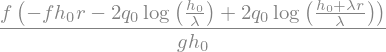

In [291]:
detadr_ana = sol.subs(c1,bc1).diff(r).simplify()
detadr_ana

In [292]:
F_eta = sym.lambdify( (r, f,h0,l,q0,g), eta_ana, 'numpy')
F_detadr = sym.lambdify( (r, f,h0,l,q0,g), detadr_ana, 'numpy')

In [293]:
rn = np.linspace(1,10e3,1000)
fs = F_eta(rn, -3e-5, 20, 0.1, 20*0.25,9.81)
dfs = F_detadr(rn, -3e-5, 20, 0.1, 20*0.25,9.81)

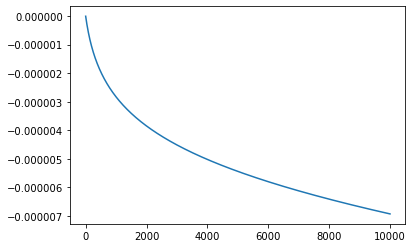

In [310]:
#sns.lineplot(rn,fs)
sns.lineplot(rn,dfs)

In [312]:
def gradient_wind(r, f, dndr, g = 9.81):
    return -r*f/2 + (r**2*f**2/4 - r*g*dndr)**(0.5), \
           -r*f/2 - (r**2*f**2/4 - r*g*dndr)**(0.5)

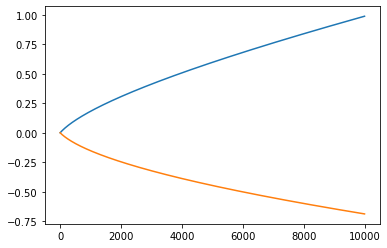

In [315]:
vt1, vt2 = gradient_wind(rn, -3e-5, dfs)

sns.lineplot(rn,vt1)
sns.lineplot(rn,vt2)